In [4]:
img_path.exists()

False

vit_small_patch14_reg4_dinov2


Text(0.5, 1.0, 'Fear: 63/100')

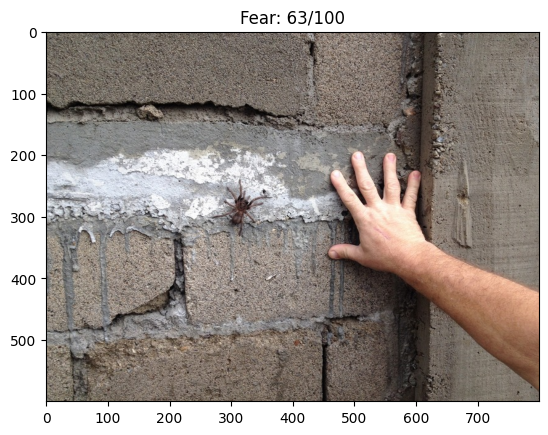

In [24]:
import os
import pickle
import io
from model_loader import create_model
from pathlib import Path
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from transforms import get_data_transforms


# img_path = Path("checkpoint", "Sp_146.jpg")
img_path = Path("/home", "user", "Dropbox", "data_export", "spidernets-analysis", "stimuli", "Sp_111.jpg")

is_transformer = True
device = "cpu"

transform = get_data_transforms(224, use_bicubic=is_transformer)["val"]

with open(Path("checkpoint", "run_config.json")) as fp:
    run_config = json.load(fp)

params = {}
with open(
    Path(
        "checkpoint",
        f"params_feature_extraction.json",
    ),
    encoding="utf-8",
) as fp:
    params["feature_extraction"] = json.load(fp)
with open(
    Path(
        "checkpoint",
        f"params_fine_tuning.json",
    ),
    encoding="utf-8",
) as fp:
    params["fine_tuning"] = json.load(fp)



img_ar = cv2.imread(img_path)
img_ar = cv2.cvtColor(img_ar, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img_ar)
img_t = transform(img).unsqueeze(0)

m = create_model(
    run_config,
    n_layers=params["feature_extraction"]["n_layers"],
    dropout=params["feature_extraction"]["dropout"],
    n_dense=256,
    feature_extraction=False,
)

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

checkpoint_path = Path("checkpoint", "checkpoint_fine_tuning.pth")

with open(checkpoint_path, "rb") as fp:
    checkpoint = CPU_Unpickler(fp).load()

m.load_state_dict(checkpoint)

m.eval();

with torch.no_grad():
    output = m(img_t)
    output = output.cpu().numpy().squeeze()

fear = np.max([output, 0])
fear = np.min((fear, 100))

# del m
print(run_config["model_name"])
plt.imshow(img_ar)
plt.title(f"Fear: {fear:.0f}/100")

GradCAM

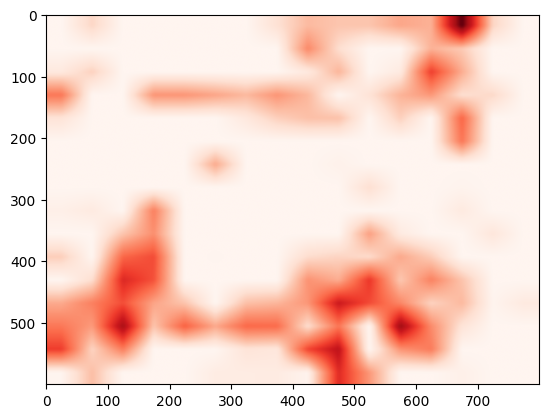

In [25]:
from pytorch_grad_cam import GradCAM

from gradcam import (
    pick_cam_targets,
    RegressionOutputTarget,
)


target_layers, reshape_tf = pick_cam_targets(
    m, run_config["model_name"]
)
cam = GradCAM(
    model=m,
    target_layers=target_layers,
    reshape_transform=reshape_tf,
)
cam_target = [RegressionOutputTarget(0)]

# Grad-CAM map (returned as numpy, HxW in input resolution)
grayscale_cam = cam(
    input_tensor=img_t, targets=cam_target
)[
    0
]  # (H, W), [0,1]

cam_resized = cv2.resize(
    grayscale_cam,
    (img.width, img.height),
    interpolation=cv2.INTER_LINEAR,
)

plt.imshow(cam_resized, cmap="Reds")

## Convert Torch-Model to ONNX

In [73]:
m_onnx = torch.onnx.export(m, img, dynamo=True)

[torch.onnx] Obtain model graph for `VisionTransformer([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `VisionTransformer([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


In [ ]:
m_onnx.save("model.onnx")

In [75]:
m_onnx(img)

(tensor([[59.4241]]),)